## Implementation of paper
### LEARNING TO PROTECT COMMUNICATIONS WITH ADVERSARIAL NEURAL CRYPTOGRAPHY

1. Model
- one 2n x 2n FC layer
- 4 convolutional layers with [kernel size, in channel, out channel, padding] as below :  
- [4,1,2,1], [2,2,4,2], [1,4,4,1], [1,4,1,1] 
- Strides : 1, 2, 1, 1

In [13]:
import os

SRC_DIR = os.path.abspath(os.path.curdir)
ROOT_MOD_DIR = "/".join(SRC_DIR.split("/")[:-1])
LIB_DIR = os.path.join(ROOT_MOD_DIR, "lib")
CHECKPOINT_DIR = os.path.join(LIB_DIR, "chkpts")

pth_exists_else_mk = lambda path: os.mkdir(path) if not os.path.exists(path) else None

pth_exists_else_mk(LIB_DIR)
pth_exists_else_mk(CHECKPOINT_DIR)


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

class Communicators(torch.nn.Module):
    def __init__(self, N):              # N is number of dimensions.
        super(Communicators, self).__init__()
        self.fc_layer = torch.nn.Linear(2*N, 2*N)   # N bit values, N key values.
        # then we need 4 convolutional layers, such that after 4 convolutions output must be of size N.
        # output is the ciphertext.

        self.conv1 = torch.nn.Conv1d(in_channels=1 , out_channels=2, kernel_size=4, padding=2)      

        self.conv2 = torch.nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride = 2)  

        self.conv3 = torch.nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride = 1)        

        self.conv4 = torch.nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride = 1)
        
    
    def forward(self, x):
        x = x[None, :, :].transpose(0, 1)
        x = self.fc_layer(x)
        x = F.sigmoid(x)
        x = self.conv1(x)
        x = F.sigmoid(x)
        x = self.conv2(x)
        x = F.sigmoid(x)
        x = self.conv3(x)
        x = F.sigmoid(x)
        x = self.conv4(x)
        x = F.tanh(x)
        #binary_output = torch.where(x > 0, torch.tensor(1), torch.tensor(0))
        
        return torch.squeeze(x)


In [15]:
class adversary(torch.nn.Module):
    def __init__(self, N):
        super(adversary, self).__init__()
        self.fc_layer = torch.nn.Linear(N, 2*N)  # N bit encrypted values as input.
        self.conv1 = torch.nn.Conv1d(in_channels=1 , out_channels=2, kernel_size=4, padding=2)      

        self.conv2 = torch.nn.Conv1d(in_channels=2, out_channels=4, kernel_size=2, stride = 2)  

        self.conv3 = torch.nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1, stride = 1)        

        self.conv4 = torch.nn.Conv1d(in_channels=4, out_channels=1, kernel_size=1, stride = 1)

    def forward(self, x):
        x = x[None, :, :].transpose(0, 1)
        x = self.fc_layer(x)
        x = F.sigmoid(x)
        x = self.conv1(x)
        x = F.sigmoid(x)
        x = self.conv2(x)
        x = F.sigmoid(x)
        x = self.conv3(x)
        x = F.sigmoid(x)
        x = self.conv4(x)
        x = F.tanh(x)
        #binary_output = torch.where(x > 0, torch.tensor(1), torch.tensor(0))
        # binary_output = x
        return torch.squeeze(x)

In [16]:
def get_binary_data(batch,len):
    binary_input = (2*torch.randint(low = 0, high = 2, size = (batch, len)) - 1).float() 
    binary_input.requires_grad_(True)
    return binary_input

In [22]:
steps = []
bob_rc_error = []
eve_rc_error = []
ab_error = []

def train(batch_size, lr, iterations, size, save = False, checkpoint = 1000):
    #defining some hyperparameters.
    batch_size = batch_size     # 256 - 4096. # paper used 4096
    lr = lr                     # as per the paper.
    iterations = iterations     # paper used 25000
    size = size                 # size of the input data.


    alice = Communicators(size)
    bob = Communicators(size)
    eve = adversary(size)
    
    alice.train()
    bob.train()
    eve.train()


    #optimisers
    optimser_alice = Adam(params = alice.parameters(), lr = lr)
    optimser_bob = Adam(params = bob.parameters(), lr = lr)
    optimser_eve = Adam(params = eve.parameters(), lr = lr)

    for i in range(iterations):
        # train alice and bob 1 time.
        
        plain = get_binary_data(batch_size, size)
        key = get_binary_data(batch_size, size)

        alice_c = alice.forward(torch.cat((plain, key), dim = 1))
        # print(alice_c.shape)
        bob_p = bob.forward(torch.cat((alice_c, key), dim = 1))
        eve_p = eve.forward(alice_c)

        # loss functions page no. 6.
        error_bob = nn.L1Loss()(bob_p, plain)/2.0
        error_eve = nn.L1Loss()(eve_p, plain)/2.0
        ab_loss = error_bob + (1.0 - error_eve*2)**2

        optimser_alice.zero_grad()
        optimser_bob.zero_grad()
        ab_loss.backward()
        #clipping the gradients is not done.

        optimser_alice.step()
        optimser_bob.step()

        # train eve 2 times.
        for j in range(2):
            plain = get_binary_data(batch_size,size)
            key = get_binary_data(batch_size,size)
            alice_c = alice.forward(torch.cat((plain, key), dim = 1))
            eve_p = eve.forward(alice_c)

            error_eve = nn.L1Loss()(eve_p, plain)/2.0
            optimser_eve.zero_grad()
            error_eve.backward()
            #clipping the gradients is not done.
            optimser_eve.step()
        
        steps.append(i)
        plain = get_binary_data(batch_size,size)
        key = get_binary_data(batch_size,size)
        alice_c = alice.forward(torch.cat((plain, key), dim = 1))
        bob_p = bob.forward(torch.cat((alice_c, key), dim = 1))
        eve_p = eve.forward(alice_c)

        error_bob = (nn.L1Loss()(bob_p, plain))/2.0
        error_eve = (nn.L1Loss()(eve_p, plain))/2.0

        bob_rc_error.append(error_bob.item())
        eve_rc_error.append(error_eve.item())
        ab_loss = error_bob + (1.0 - error_eve*2)**2
        ab_error.append(ab_loss.item())
        
        if i%1000 == 0:
            print("Iteration: ", i, "  Bob Loss: ", error_bob.item())
            print("Iteration: ", i, "  Eve Loss: ", error_eve.item())
            print("Iteration: ", i, "  AB Loss: ", ab_loss.item())

        if save and i%checkpoint == 0:
            torch.save(alice.state_dict(), os.path.join(CHECKPOINT_DIR, "alice.pth"))
            torch.save(bob.state_dict(), os.path.join(CHECKPOINT_DIR, "bob.pth"))
            torch.save(eve.state_dict(), os.path.join(CHECKPOINT_DIR, "eve.pth"))

    # in each iteration we will train alice,bob once and eve 2 times.

In [18]:
import matplotlib.pyplot as plt

#change the size to 20, 10
def plot_it(steps, bob_rc_error, eve_rc_error):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Reconstruction Error")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Reconstruction Error")
    ax.plot(steps, bob_rc_error, label = "Bob")
    ax.plot(steps, eve_rc_error, label = "Eve")
    ax.legend()

    plt.show()

# plt.plot(steps, bob_rc_error, label = "Bob")
# plt.plot(steps, eve_rc_error, label = "Eve")
# plt.xlabel("Iterations")
# plt.ylabel("Reconstruction Error")
# plt.legend()

# plt.show()

In [19]:
def plot_it2(steps, eve_error, ab_error):
   fig = plt.figure(figsize=(20,10))
   ax = fig.add_subplot(1,1,1)
   ax.set_title("Reconstruction Error")
   ax.set_xlabel("Iterations")
   ax.set_ylabel("Reconstruction Error")
   ax.plot(steps, eve_error, label = "Eve")
   ax.plot(steps, ab_error, label = "alice-bob")
   ax.legend()

   plt.show()

In [20]:
def load():
    alice = Communicators(16)
    bob = Communicators(16)
    eve = adversary(16)

    alice.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, "alice.pth")))
    bob.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, "bob.pth")))
    eve.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, "eve.pth")))
    return alice, bob, eve

In [31]:
steps = []
bob_rc_error = []
eve_rc_error = []
ab_error = []
train(batch_size = 512, lr = 0.0008, iterations = 25000, size = 16, save=True)

Iteration:  0   Bob Loss:  0.5004618167877197
Iteration:  0   Eve Loss:  0.49920910596847534
Iteration:  0   AB Loss:  0.5004643201828003
Iteration:  1000   Bob Loss:  0.5006114840507507
Iteration:  1000   Eve Loss:  0.4993774890899658
Iteration:  1000   AB Loss:  0.5006130337715149
Iteration:  2000   Bob Loss:  0.4998170733451843
Iteration:  2000   Eve Loss:  0.5002234578132629
Iteration:  2000   AB Loss:  0.49981728196144104
Iteration:  3000   Bob Loss:  0.5020536184310913
Iteration:  3000   Eve Loss:  0.500033438205719
Iteration:  3000   AB Loss:  0.5020536184310913
Iteration:  4000   Bob Loss:  0.49874499440193176
Iteration:  4000   Eve Loss:  0.4846818149089813
Iteration:  4000   AB Loss:  0.49968358874320984
Iteration:  5000   Bob Loss:  0.1382620930671692
Iteration:  5000   Eve Loss:  0.3747842609882355
Iteration:  5000   AB Loss:  0.20097801089286804
Iteration:  6000   Bob Loss:  0.041713859885931015
Iteration:  6000   Eve Loss:  0.3823671042919159
Iteration:  6000   AB Loss:  

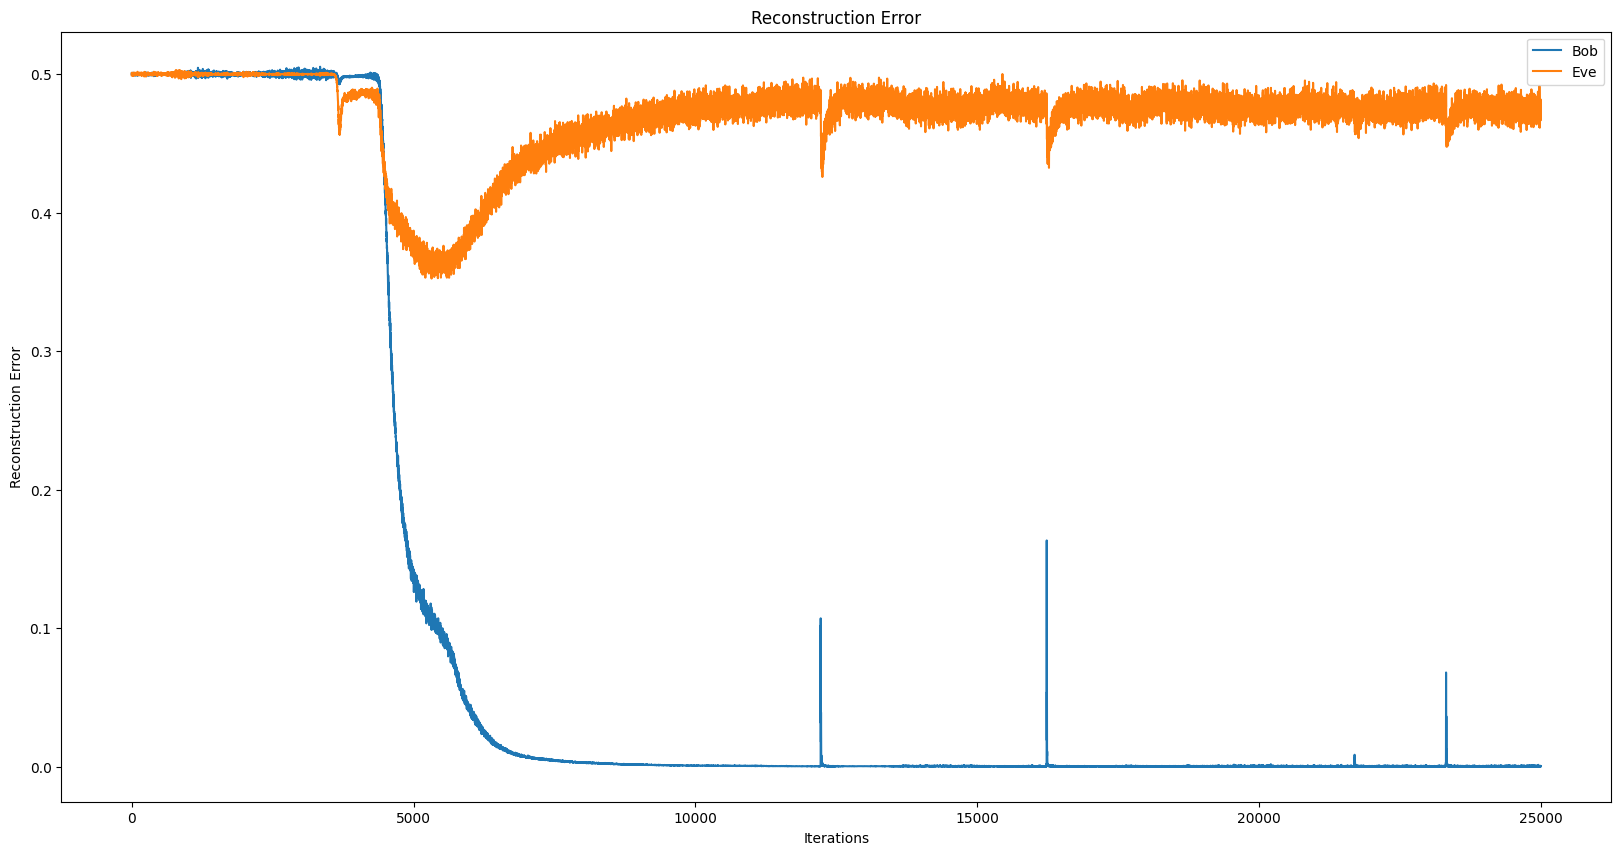

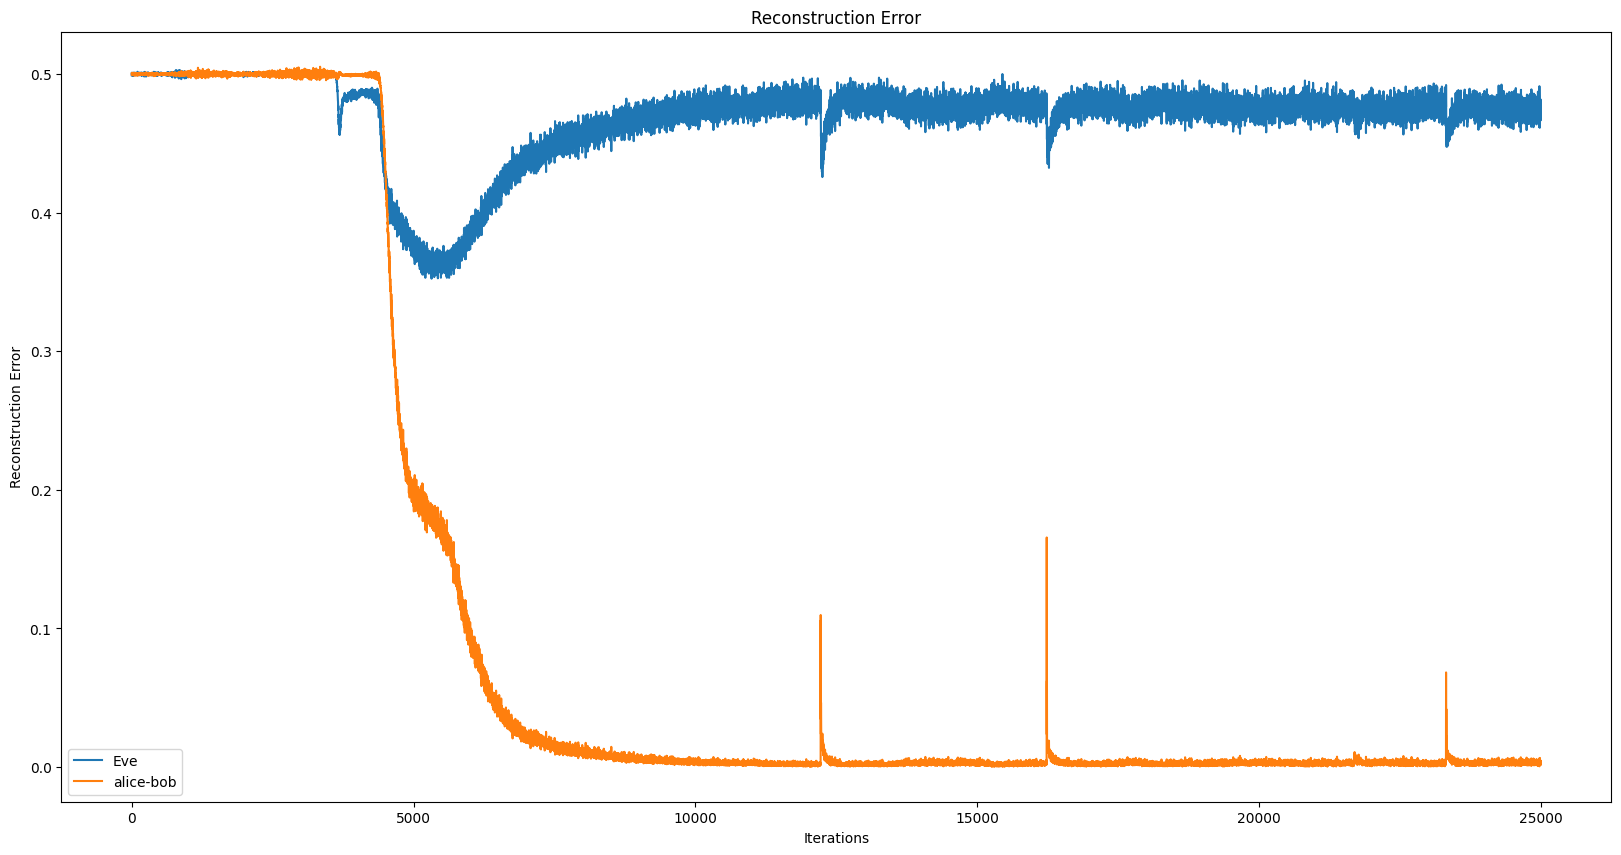

In [32]:
plot_it(steps, bob_rc_error, eve_rc_error)
plot_it2(steps, eve_rc_error, ab_error)

### ```From here, some experimentation by changing lr, batch size and size seperately. ```

Iteration:  0   Bob Loss:  0.5001196265220642
Iteration:  0   Eve Loss:  0.4999799132347107
Iteration:  0   AB Loss:  0.5001196265220642
Iteration:  1000   Bob Loss:  0.49999964237213135
Iteration:  1000   Eve Loss:  0.5000002384185791
Iteration:  1000   AB Loss:  0.49999964237213135
Iteration:  2000   Bob Loss:  0.49844467639923096
Iteration:  2000   Eve Loss:  0.500255823135376
Iteration:  2000   AB Loss:  0.49844494462013245
Iteration:  3000   Bob Loss:  0.49858686327934265
Iteration:  3000   Eve Loss:  0.4975227415561676
Iteration:  3000   AB Loss:  0.4986114203929901
Iteration:  4000   Bob Loss:  0.4996025860309601
Iteration:  4000   Eve Loss:  0.4973328709602356
Iteration:  4000   AB Loss:  0.49963104724884033
Iteration:  5000   Bob Loss:  0.49806320667266846
Iteration:  5000   Eve Loss:  0.49940750002861023
Iteration:  5000   AB Loss:  0.4980646073818207
Iteration:  6000   Bob Loss:  0.1511034071445465
Iteration:  6000   Eve Loss:  0.3482929468154907
Iteration:  6000   AB Loss: 

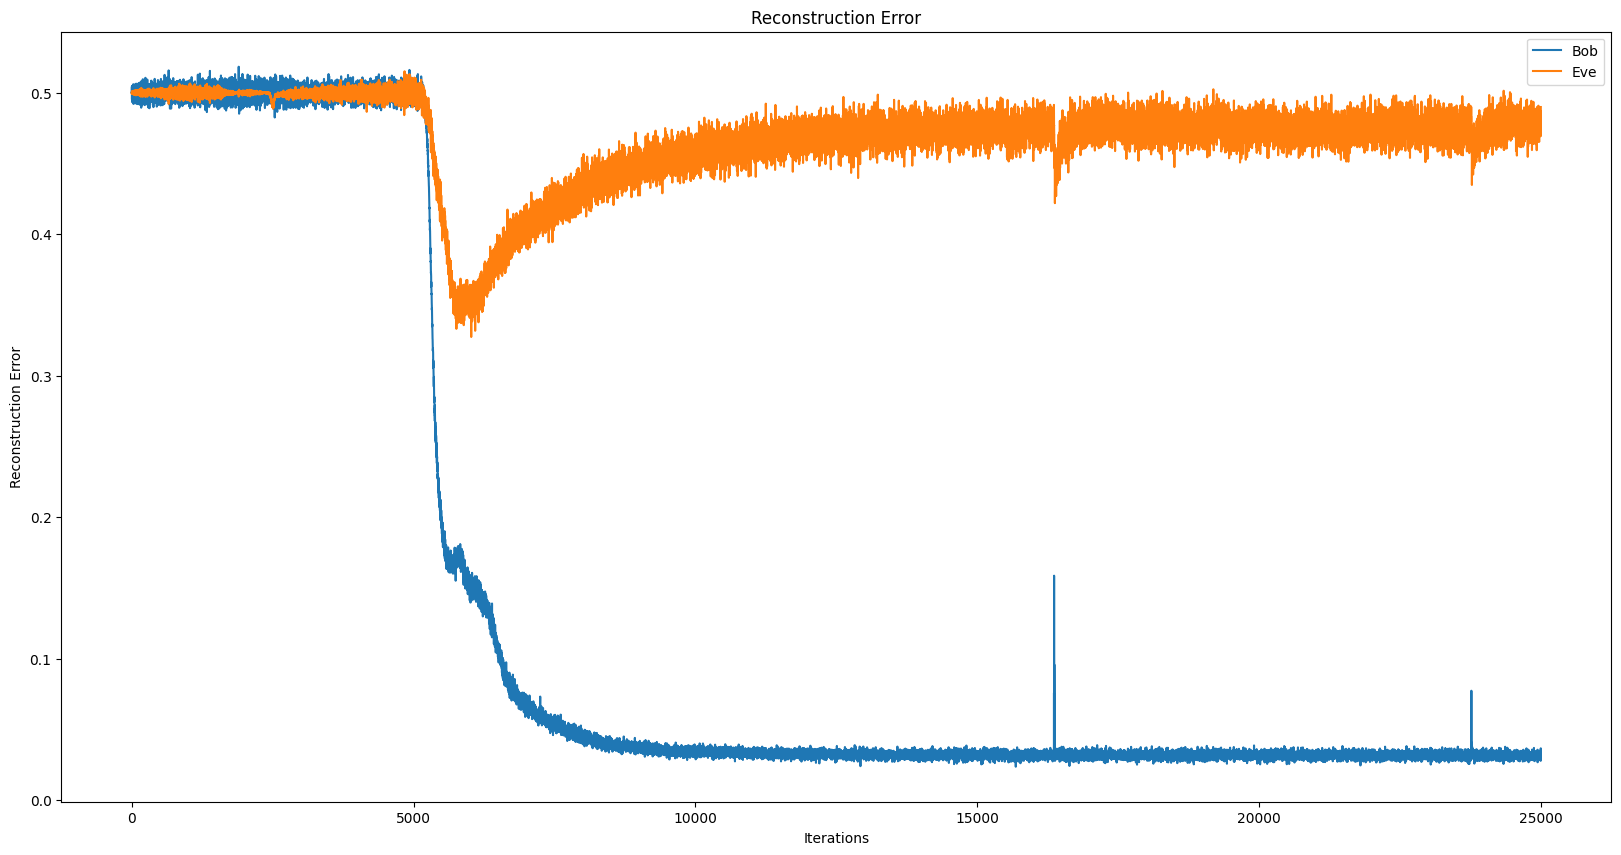

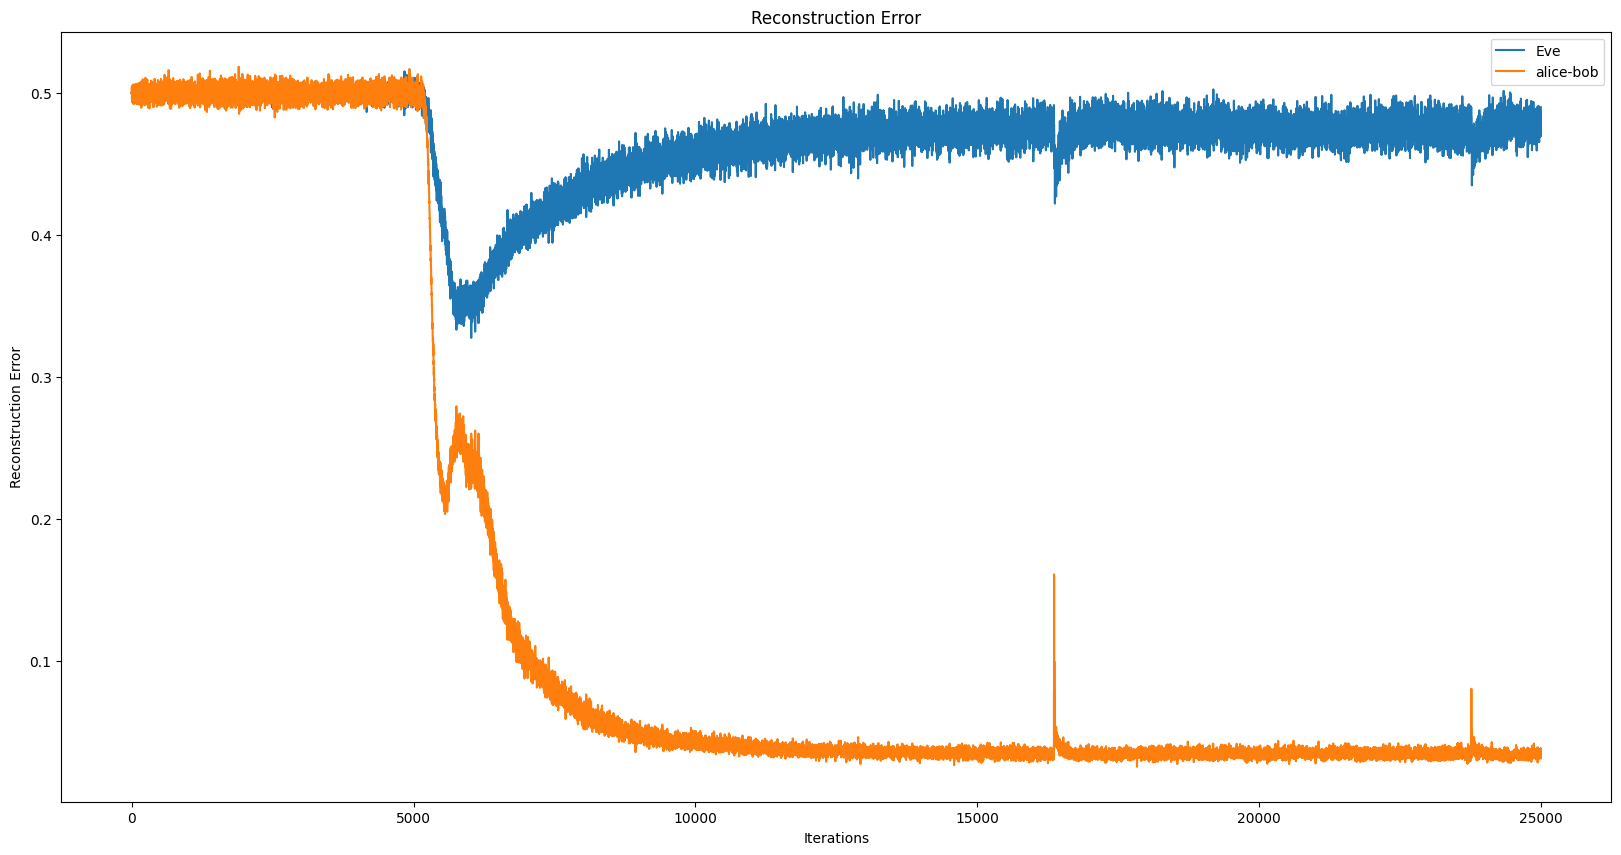

In [27]:
steps = []
bob_rc_error = []
eve_rc_error = []
ab_error = []
train(batch_size = 256, lr = 0.0008, iterations = 25000, size = 16)

plot_it(steps, bob_rc_error, eve_rc_error)
plot_it2(steps, eve_rc_error, ab_error)

Iteration:  0   Bob Loss:  0.4959820806980133
Iteration:  0   Eve Loss:  0.5023466944694519
Iteration:  0   AB Loss:  0.4960041046142578
Iteration:  1000   Bob Loss:  0.5022894144058228
Iteration:  1000   Eve Loss:  0.4983866214752197
Iteration:  1000   AB Loss:  0.5022998452186584
Iteration:  2000   Bob Loss:  0.5018264055252075
Iteration:  2000   Eve Loss:  0.4979400038719177
Iteration:  2000   AB Loss:  0.5018433928489685
Iteration:  3000   Bob Loss:  0.49860262870788574
Iteration:  3000   Eve Loss:  0.5007644891738892
Iteration:  3000   AB Loss:  0.498604953289032
Iteration:  4000   Bob Loss:  0.49939343333244324
Iteration:  4000   Eve Loss:  0.500370979309082
Iteration:  4000   AB Loss:  0.4993939697742462
Iteration:  5000   Bob Loss:  0.49945583939552307
Iteration:  5000   Eve Loss:  0.5011985301971436
Iteration:  5000   AB Loss:  0.4994615912437439
Iteration:  6000   Bob Loss:  0.4994746148586273
Iteration:  6000   Eve Loss:  0.49149951338768005
Iteration:  6000   AB Loss:  0.49

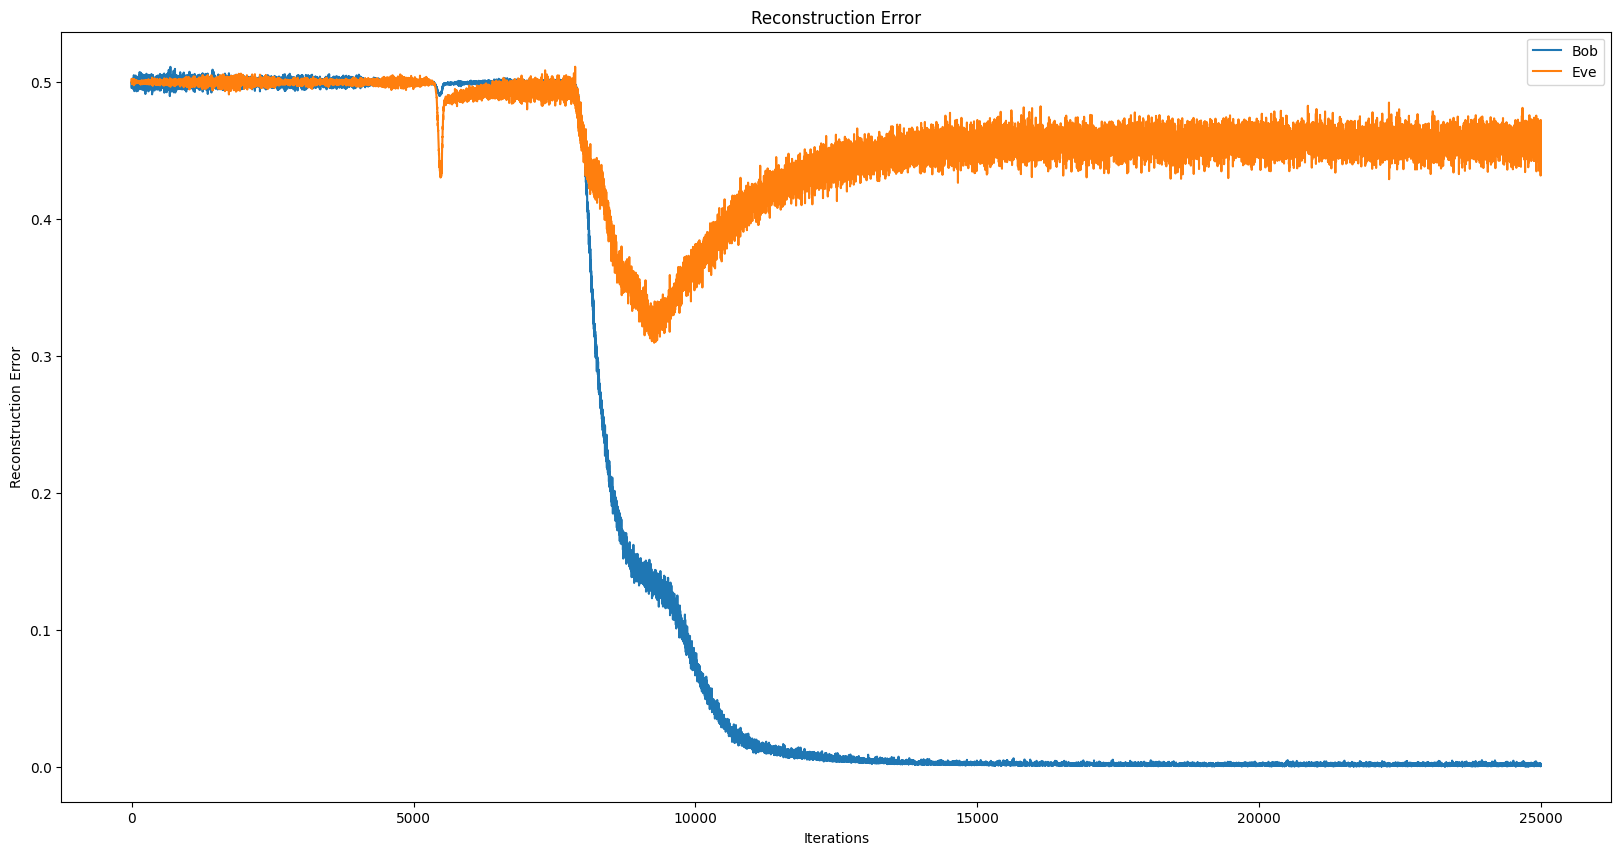

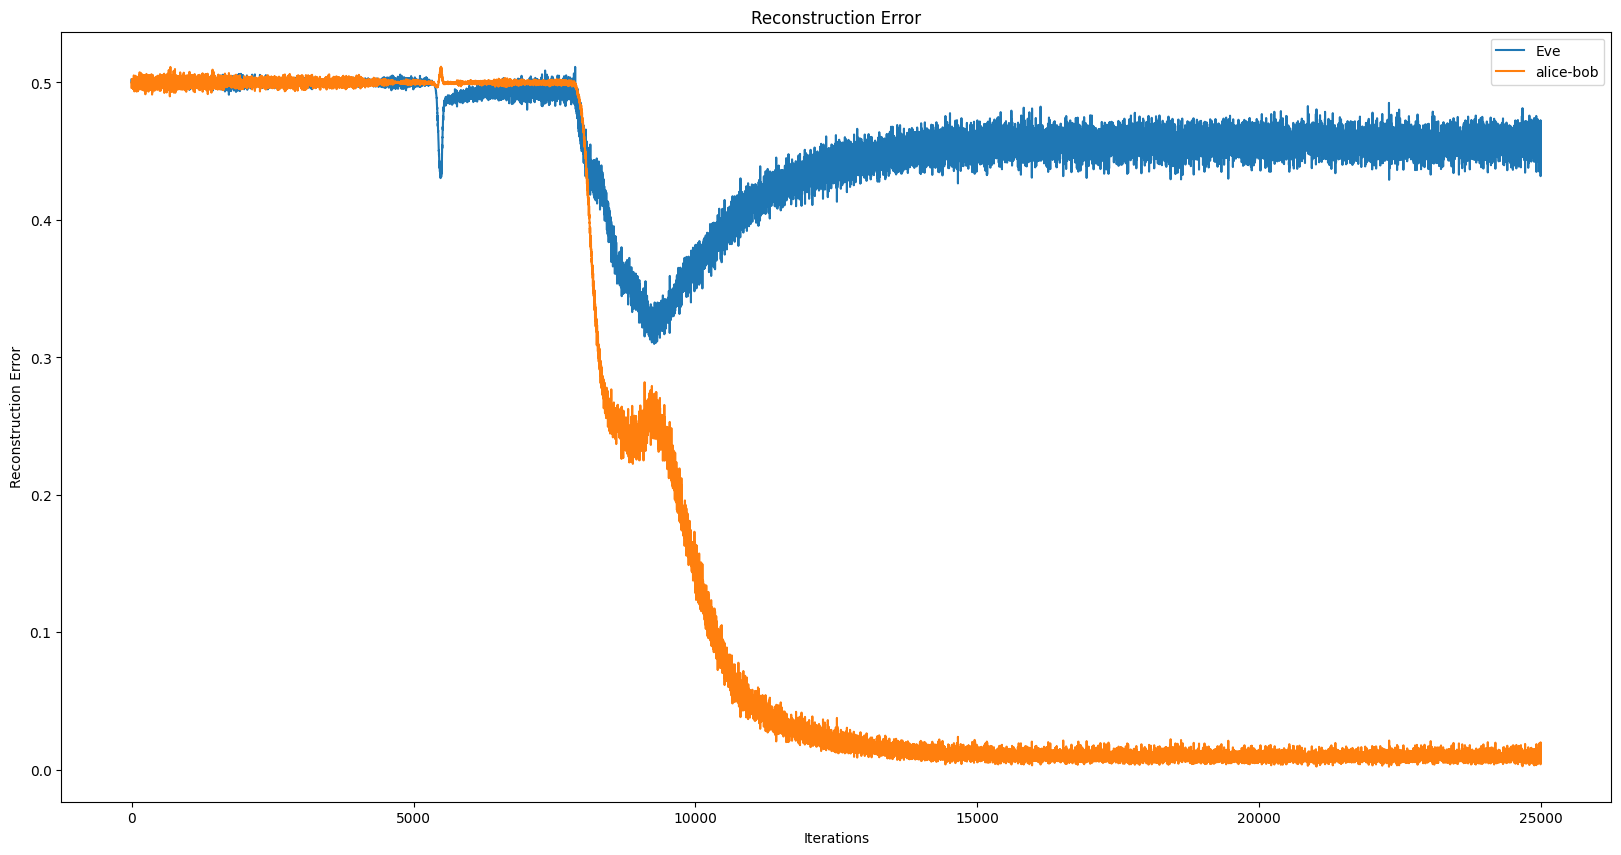

In [24]:
steps = []
bob_rc_error = []
eve_rc_error = []
ab_error = []
train(batch_size = 128, lr = 0.0008, iterations = 25000, size = 32)

plot_it(steps, bob_rc_error, eve_rc_error)
plot_it2(steps, eve_rc_error, ab_error)

Iteration:  0   Bob Loss:  0.49850523471832275
Iteration:  0   Eve Loss:  0.498553991317749
Iteration:  0   AB Loss:  0.4985136091709137
Iteration:  1000   Bob Loss:  0.4971177577972412
Iteration:  1000   Eve Loss:  0.49579063057899475
Iteration:  1000   AB Loss:  0.49718862771987915
Iteration:  2000   Bob Loss:  0.5027106404304504
Iteration:  2000   Eve Loss:  0.503078043460846
Iteration:  2000   AB Loss:  0.5027485489845276
Iteration:  3000   Bob Loss:  0.49545323848724365
Iteration:  3000   Eve Loss:  0.4939613342285156
Iteration:  3000   AB Loss:  0.49559909105300903
Iteration:  4000   Bob Loss:  0.5001200437545776
Iteration:  4000   Eve Loss:  0.5001711249351501
Iteration:  4000   AB Loss:  0.5001201629638672
Iteration:  5000   Bob Loss:  0.5018467307090759
Iteration:  5000   Eve Loss:  0.5029911994934082
Iteration:  5000   AB Loss:  0.5018824934959412
Iteration:  6000   Bob Loss:  0.49953240156173706
Iteration:  6000   Eve Loss:  0.4993080496788025
Iteration:  6000   AB Loss:  0.

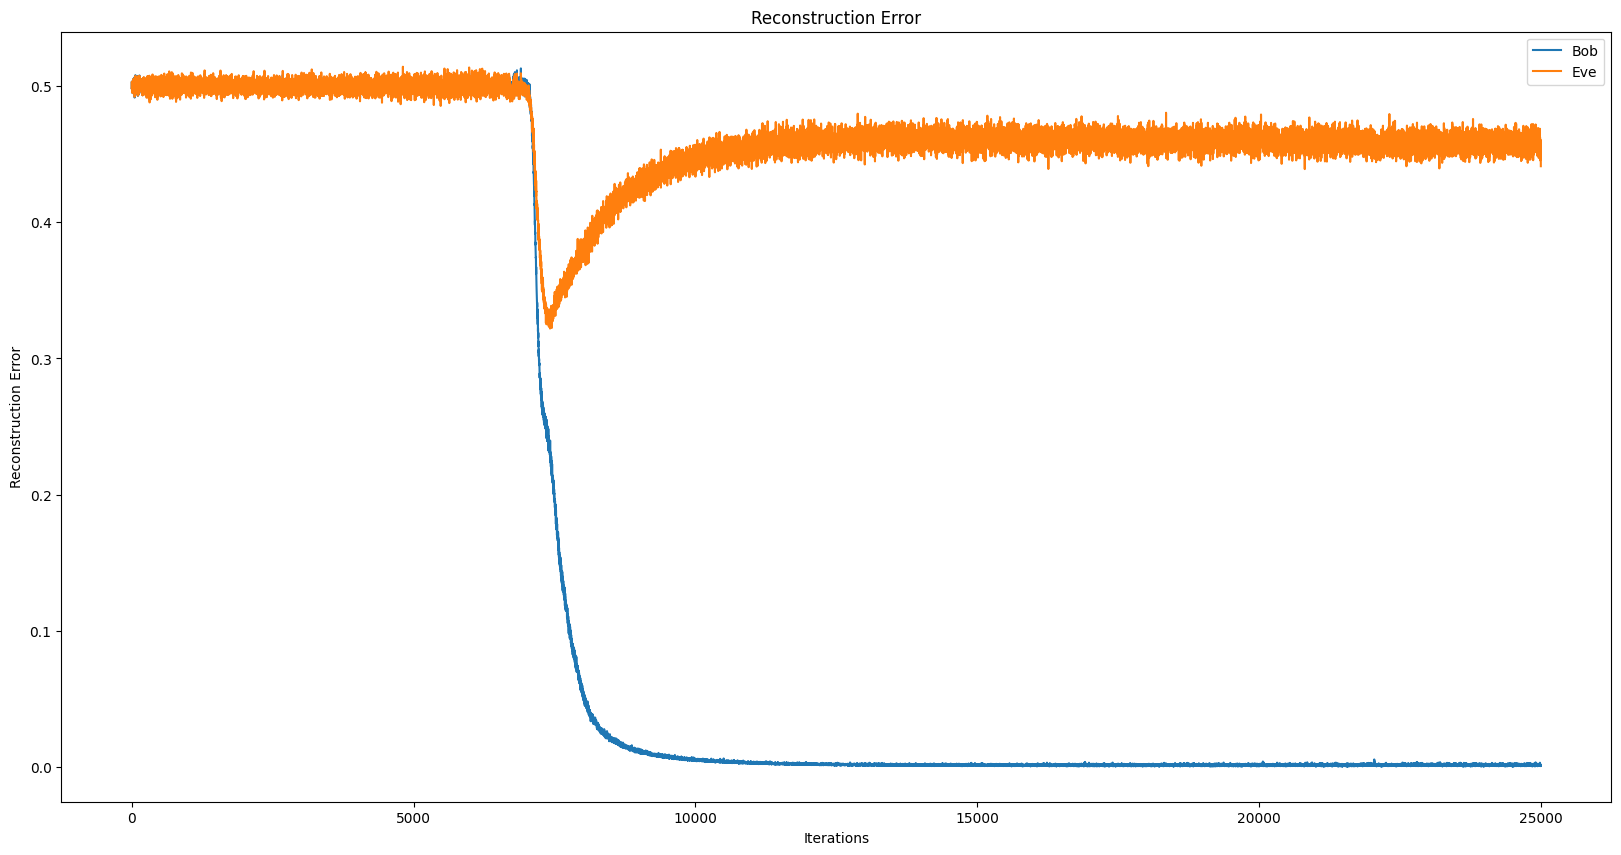

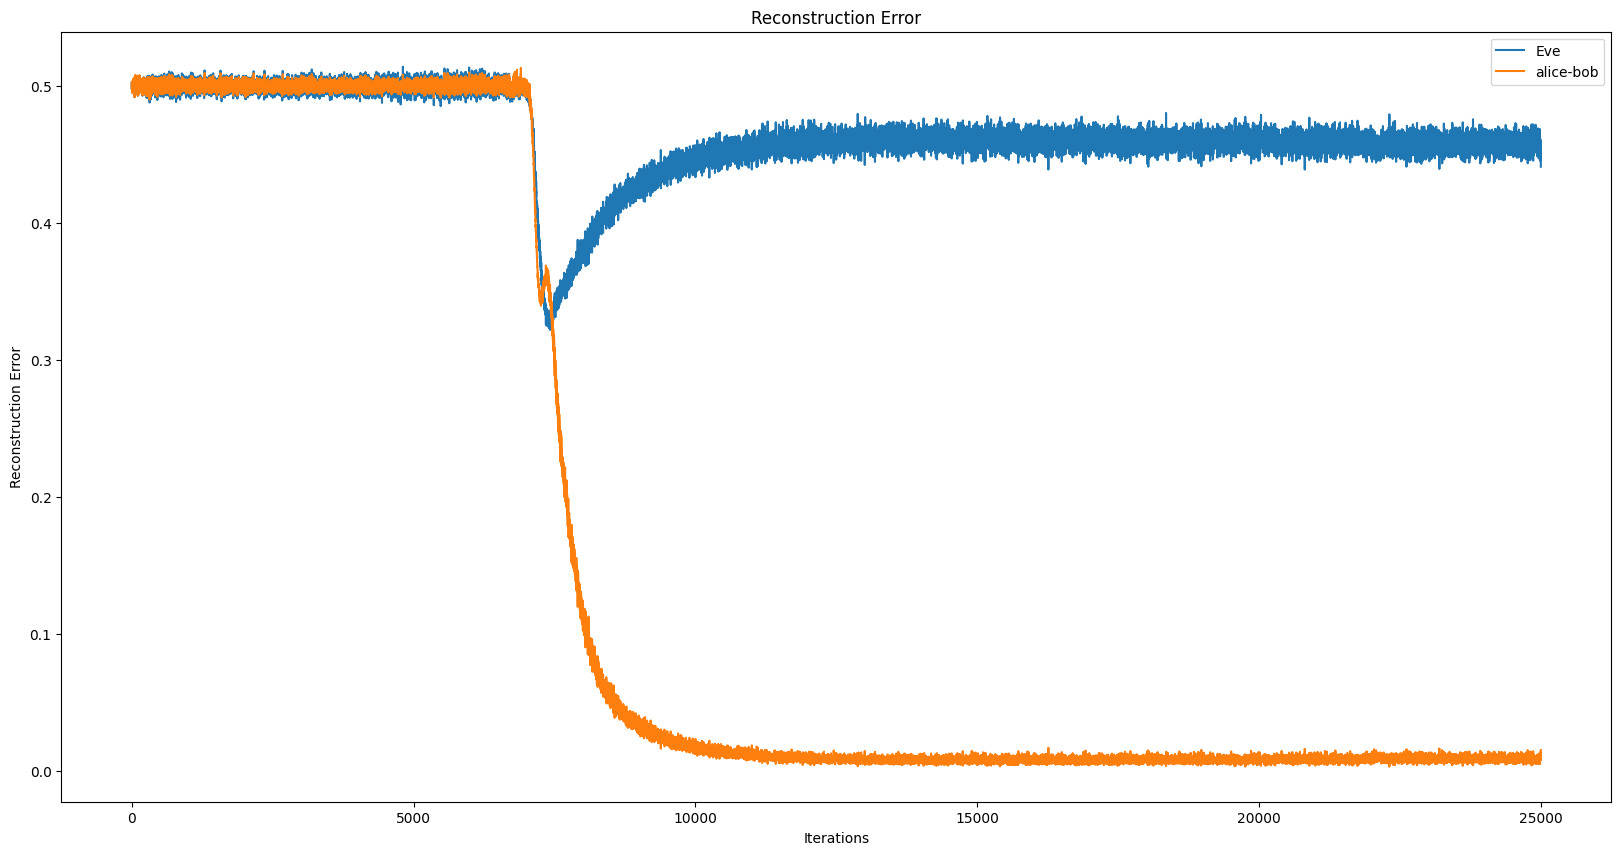

In [28]:
steps = []
bob_rc_error = []
eve_rc_error = []
ab_error = []
train(batch_size = 256, lr = 0.0008, iterations = 25000, size = 32)

plot_it(steps, bob_rc_error, eve_rc_error)
plot_it2(steps, eve_rc_error, ab_error)

Iteration:  0   Bob Loss:  0.4992921054363251
Iteration:  0   Eve Loss:  0.4997596740722656
Iteration:  0   AB Loss:  0.4992923438549042
Iteration:  1000   Bob Loss:  0.4998263418674469
Iteration:  1000   Eve Loss:  0.4999372363090515
Iteration:  1000   AB Loss:  0.4998263716697693
Iteration:  2000   Bob Loss:  0.5000467300415039
Iteration:  2000   Eve Loss:  0.5000296235084534
Iteration:  2000   AB Loss:  0.5000467300415039
Iteration:  3000   Bob Loss:  0.5002331137657166
Iteration:  3000   Eve Loss:  0.5001303553581238
Iteration:  3000   AB Loss:  0.5002331733703613
Iteration:  4000   Bob Loss:  0.5004631280899048
Iteration:  4000   Eve Loss:  0.5005592107772827
Iteration:  4000   AB Loss:  0.5004643797874451
Iteration:  5000   Bob Loss:  0.5001612901687622
Iteration:  5000   Eve Loss:  0.5001636743545532
Iteration:  5000   AB Loss:  0.5001614093780518
Iteration:  6000   Bob Loss:  0.4971281886100769
Iteration:  6000   Eve Loss:  0.4917490482330322
Iteration:  6000   AB Loss:  0.4974

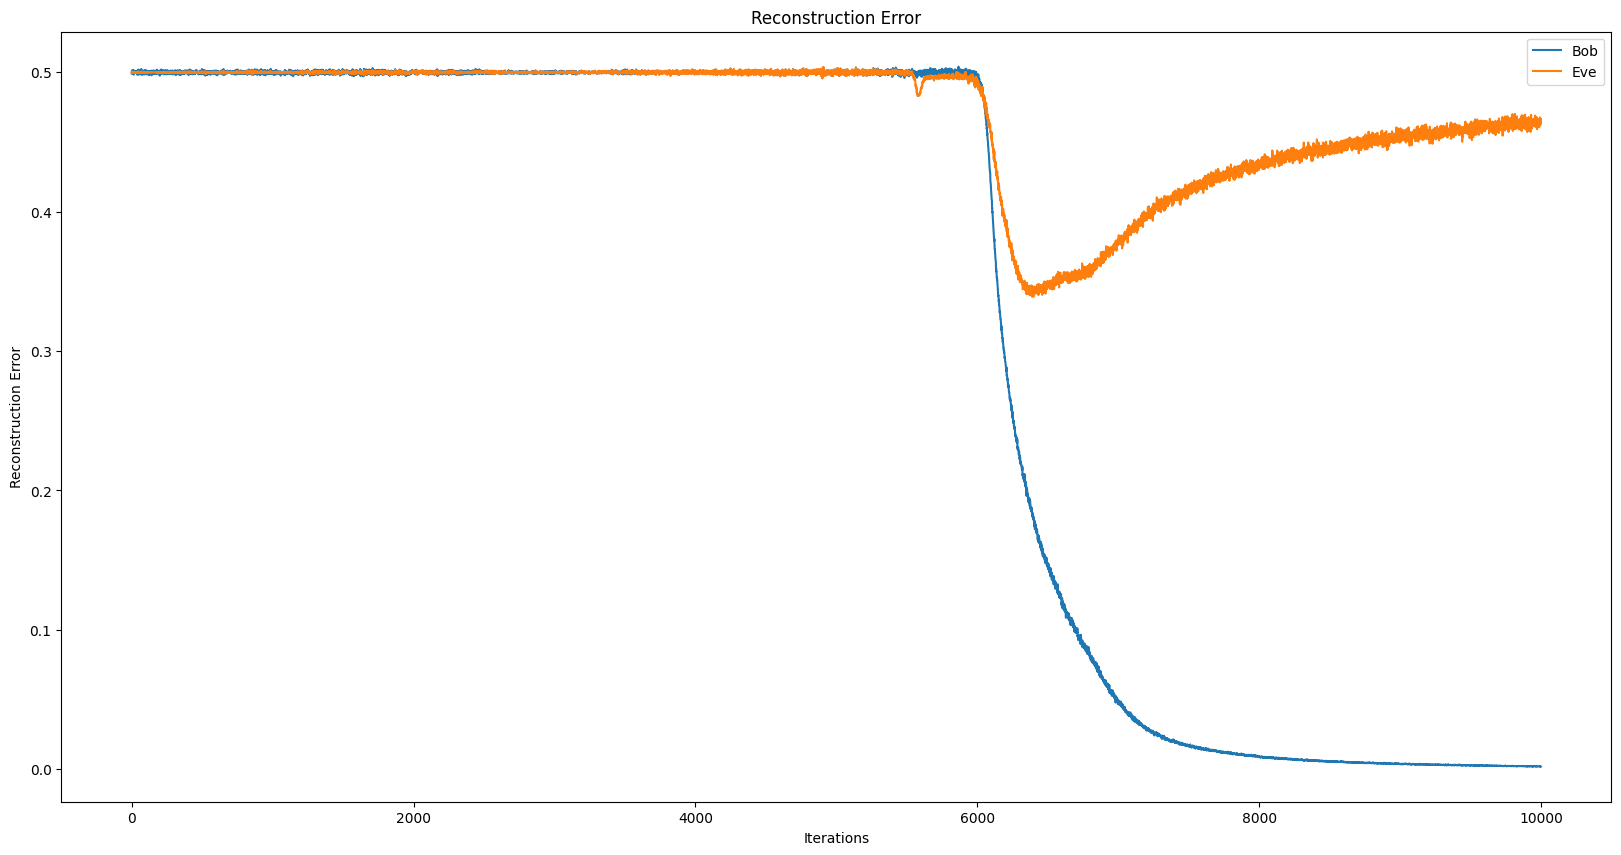

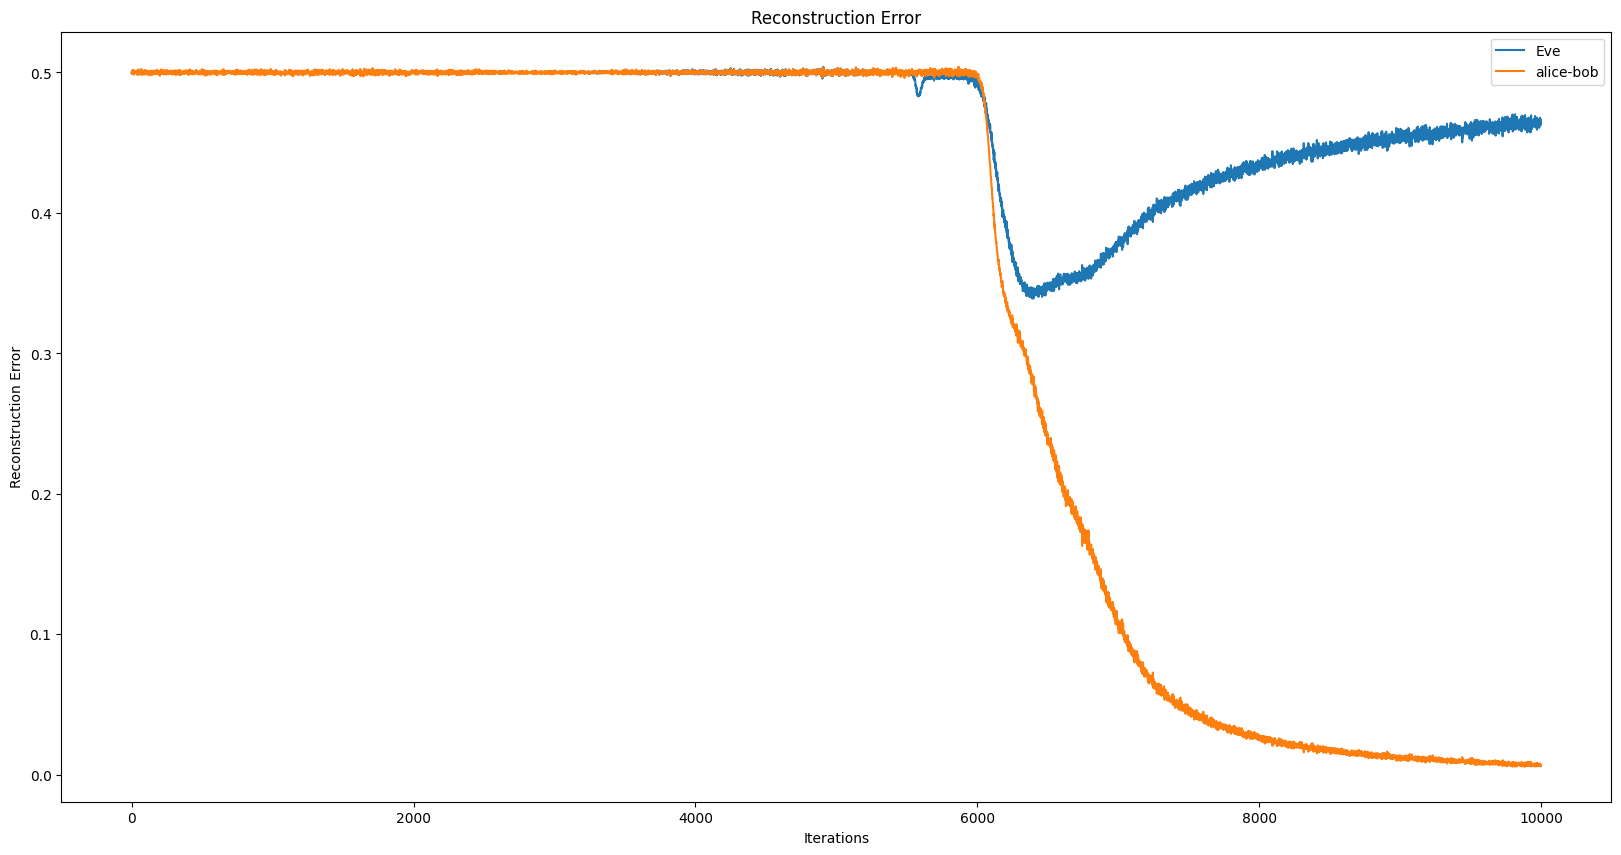

In [25]:
steps = []
bob_rc_error = []
eve_rc_error = []
ab_error = []
train(batch_size = 1024, lr = 0.0008, iterations = 10000, size = 32)

plot_it(steps, bob_rc_error, eve_rc_error)
plot_it2(steps, eve_rc_error, ab_error)

Iteration:  0   Bob Loss:  0.5001775026321411
Iteration:  0   Eve Loss:  0.506182074546814
Iteration:  0   AB Loss:  0.50033038854599
Iteration:  1000   Bob Loss:  0.49171093106269836
Iteration:  1000   Eve Loss:  0.4915952682495117
Iteration:  1000   AB Loss:  0.4919934868812561
Iteration:  2000   Bob Loss:  0.5019304752349854
Iteration:  2000   Eve Loss:  0.5019487142562866
Iteration:  2000   AB Loss:  0.5019456744194031
Iteration:  3000   Bob Loss:  0.49683862924575806
Iteration:  3000   Eve Loss:  0.4968428313732147
Iteration:  3000   AB Loss:  0.4968785047531128
Iteration:  4000   Bob Loss:  0.4941614866256714
Iteration:  4000   Eve Loss:  0.49414294958114624
Iteration:  4000   AB Loss:  0.49429869651794434
Iteration:  5000   Bob Loss:  0.507068395614624
Iteration:  5000   Eve Loss:  0.507072925567627
Iteration:  5000   AB Loss:  0.507268488407135
Iteration:  6000   Bob Loss:  0.49341195821762085
Iteration:  6000   Eve Loss:  0.4934106469154358
Iteration:  6000   AB Loss:  0.49358

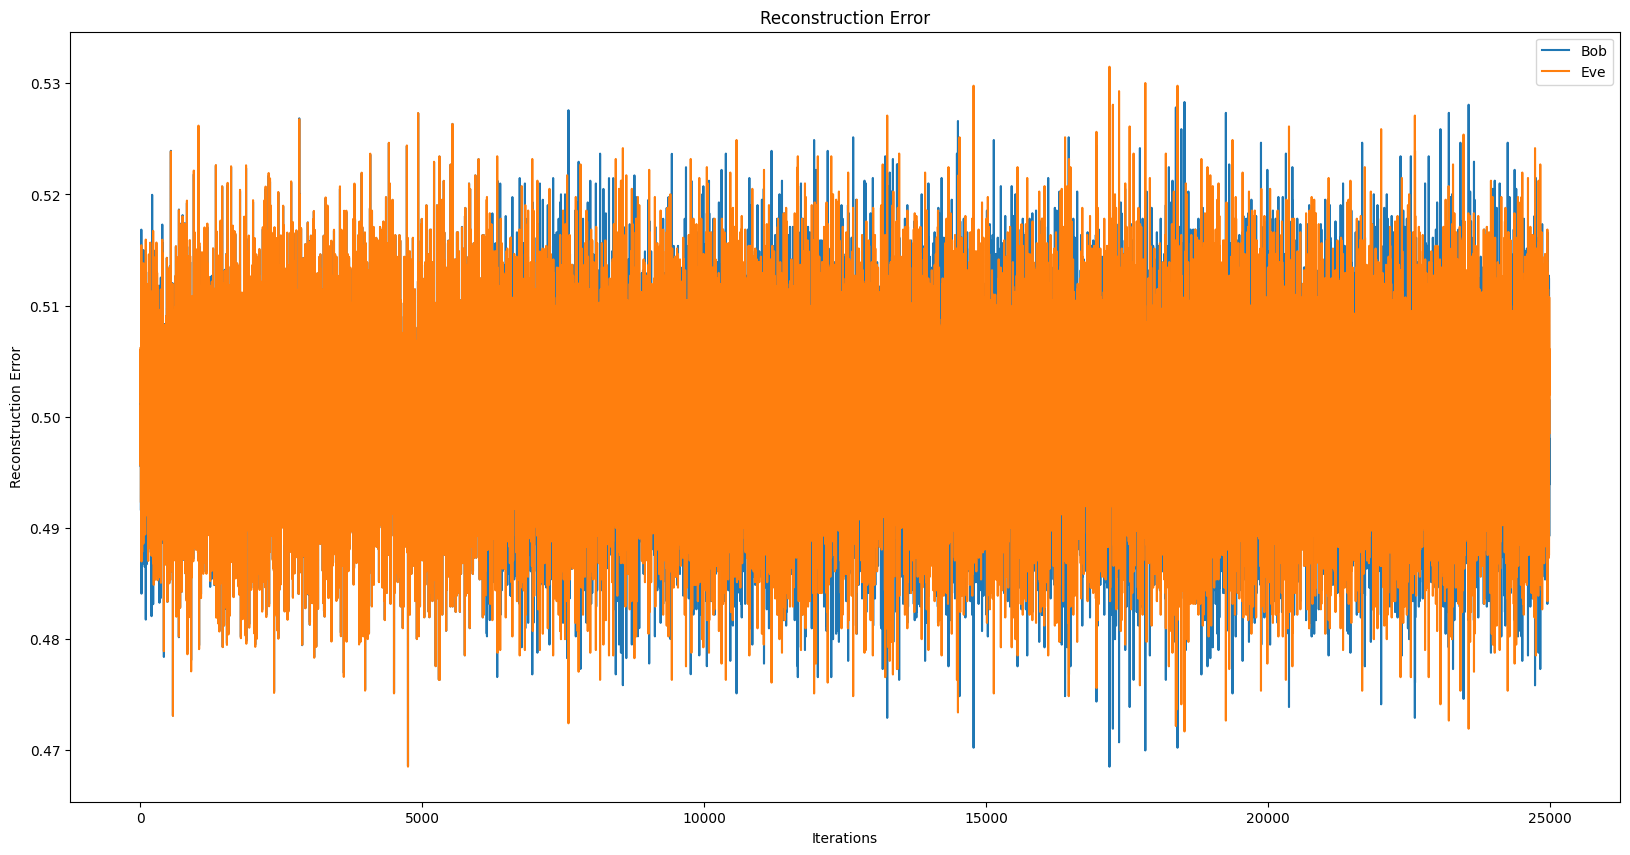

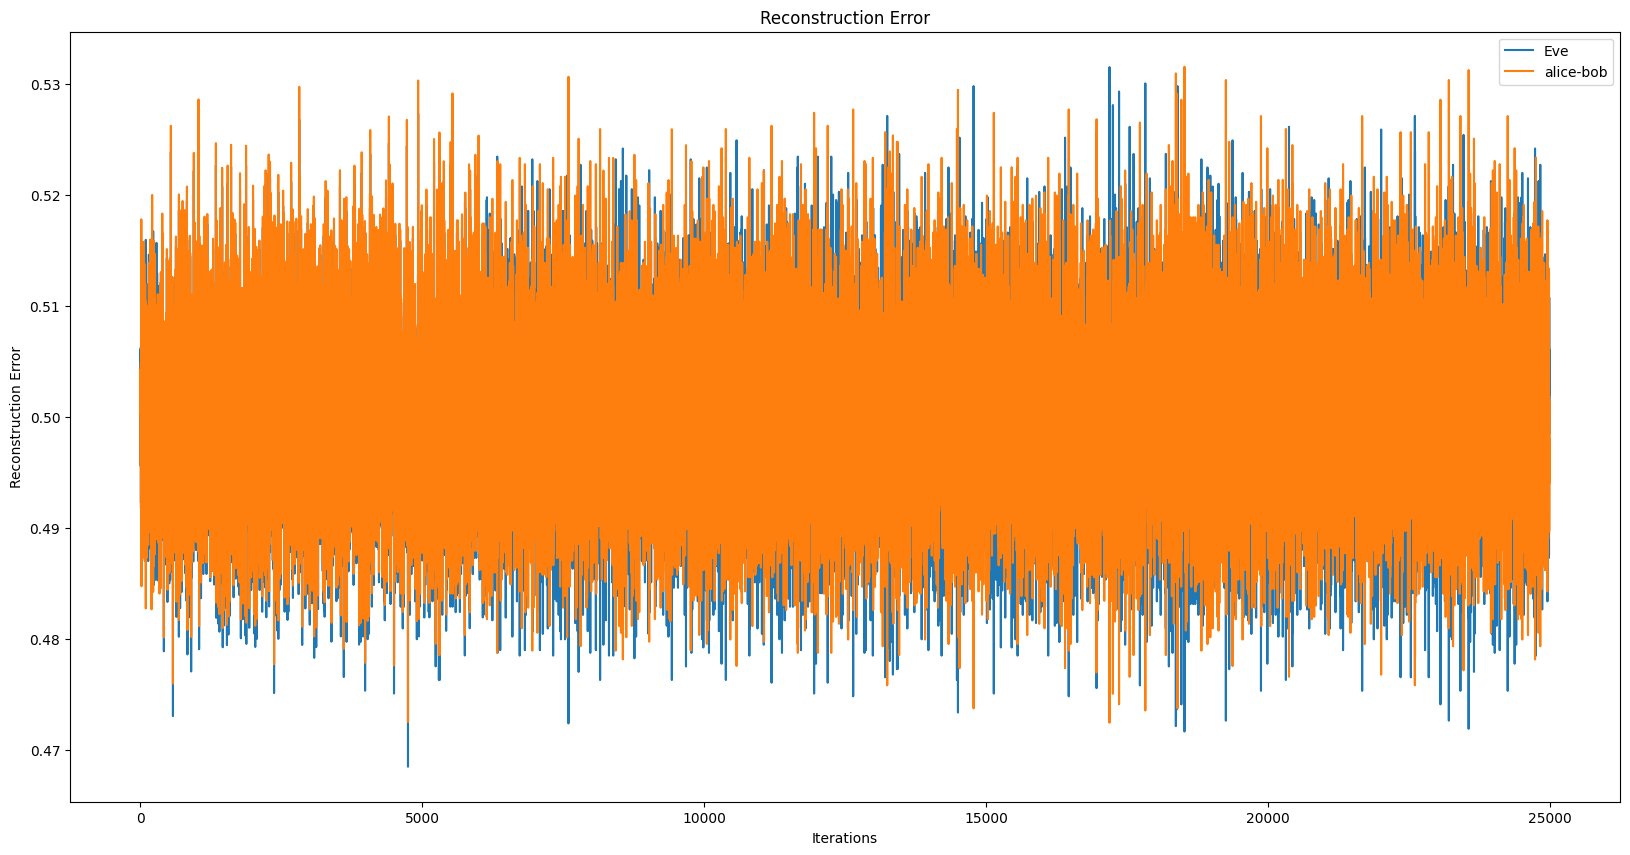

In [29]:
steps = []
bob_rc_error = []
eve_rc_error = []
ab_error = []
train(batch_size = 256, lr = 0.08, iterations = 25000, size = 16)

plot_it(steps, bob_rc_error, eve_rc_error)
plot_it2(steps, eve_rc_error, ab_error)

Iteration:  0   Bob Loss:  0.5012040734291077
Iteration:  0   Eve Loss:  0.4992148280143738
Iteration:  0   AB Loss:  0.5012065172195435
Iteration:  1000   Bob Loss:  0.49634891748428345
Iteration:  1000   Eve Loss:  0.49760520458221436
Iteration:  1000   AB Loss:  0.496371865272522
Iteration:  2000   Bob Loss:  0.5039919018745422
Iteration:  2000   Eve Loss:  0.5083457827568054
Iteration:  2000   AB Loss:  0.5042704939842224
Iteration:  3000   Bob Loss:  0.49785229563713074
Iteration:  3000   Eve Loss:  0.5021615028381348
Iteration:  3000   AB Loss:  0.4978709816932678
Iteration:  4000   Bob Loss:  0.49591928720474243
Iteration:  4000   Eve Loss:  0.4932428002357483
Iteration:  4000   AB Loss:  0.49610191583633423
Iteration:  5000   Bob Loss:  0.5012717843055725
Iteration:  5000   Eve Loss:  0.49467262625694275
Iteration:  5000   AB Loss:  0.5013853311538696
Iteration:  6000   Bob Loss:  0.49766409397125244
Iteration:  6000   Eve Loss:  0.502436637878418
Iteration:  6000   AB Loss:  0

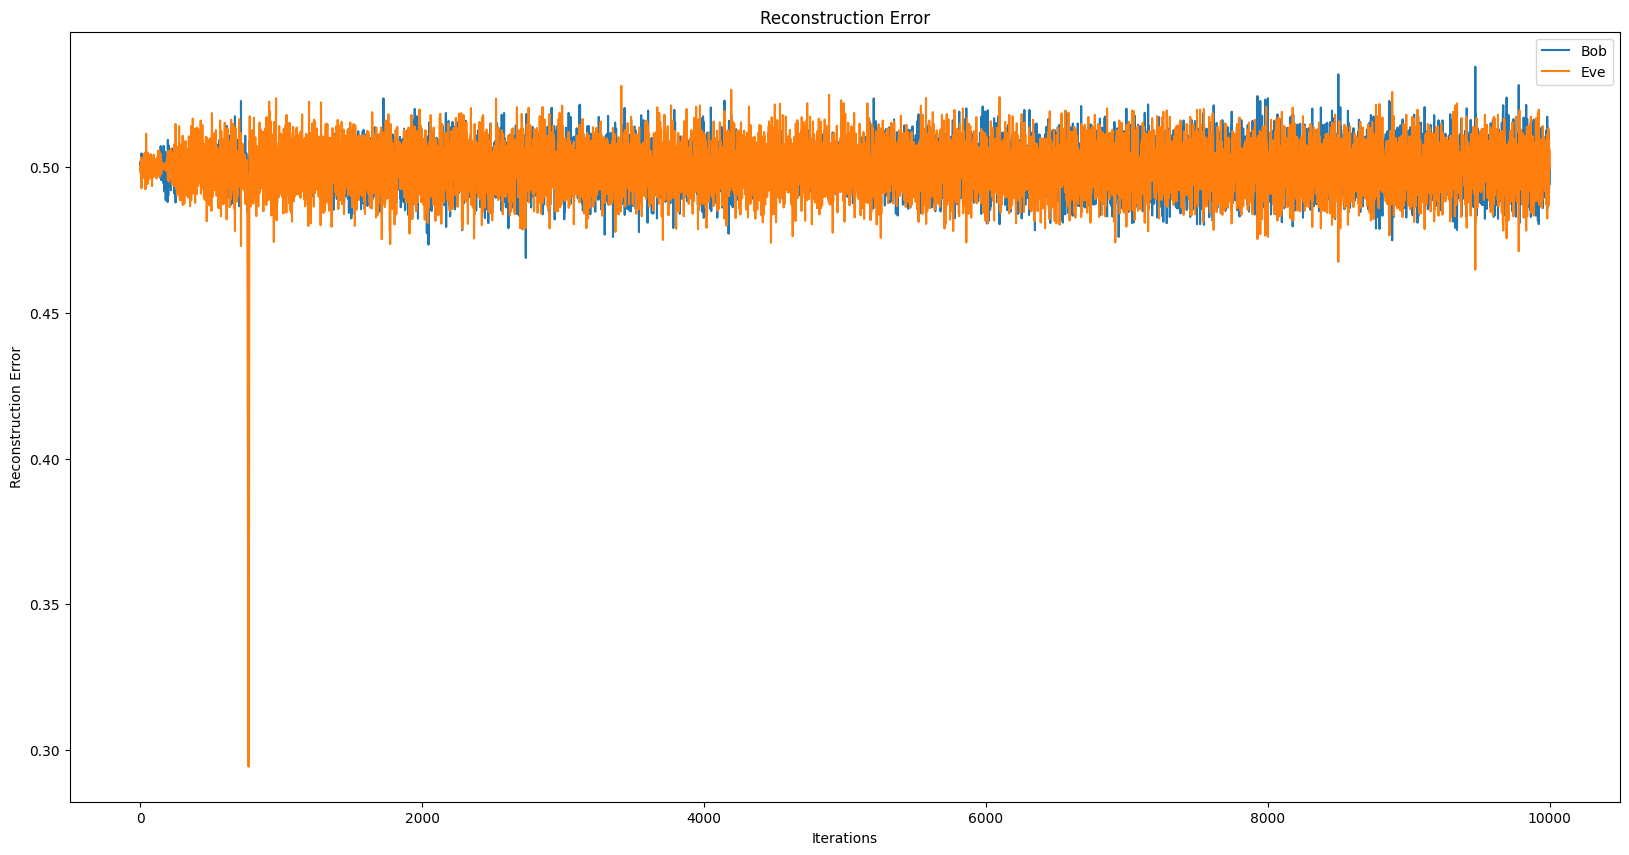

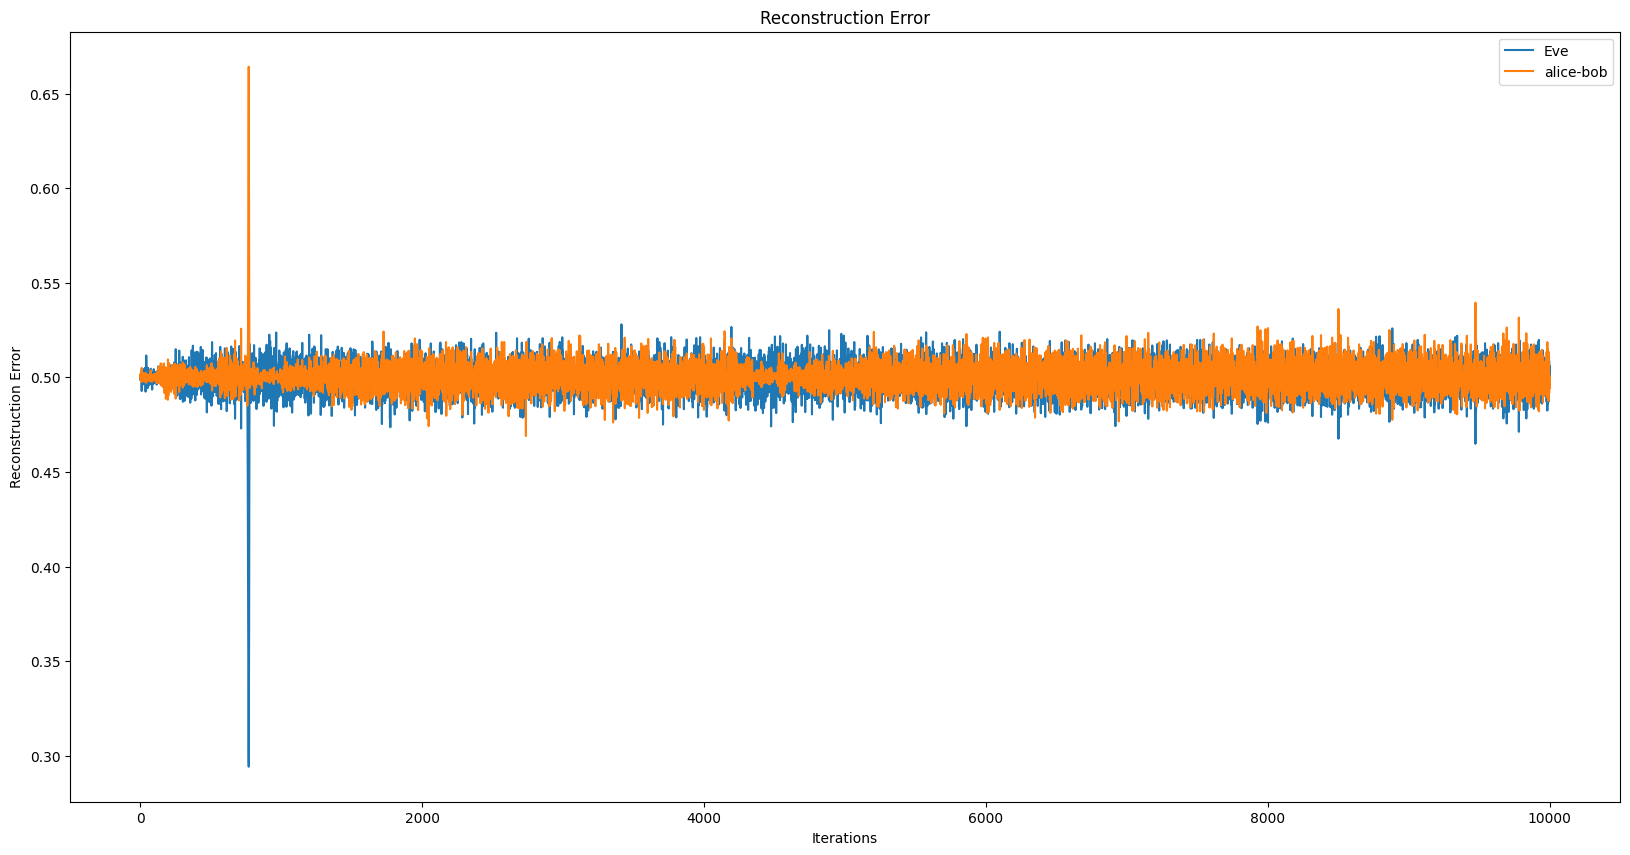

In [30]:
steps = []
bob_rc_error = []
eve_rc_error = []
ab_error = []
train(batch_size = 256, lr = 0.01, iterations = 10000, size = 16)

plot_it(steps, bob_rc_error, eve_rc_error)
plot_it2(steps, eve_rc_error, ab_error)

In [ ]:
steps = []
bob_rc_error = []
eve_rc_error = []
ab_error = []
train(batch_size = 256, lr = 0.008, iterations = 10000, size = 16)

plot_it(steps, bob_rc_error, eve_rc_error)
plot_it2(steps, eve_rc_error, ab_error)